In [2]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from typing import List, Tuple, Dict

# Common Variables

In [3]:
DATA_CACHE = Path('../data/cache/')
DATA_RAW = Path('../data/raw/')

EEG_PATH = DATA_RAW / 'train_eegs/'
SPEC_PATH = DATA_RAW / 'train_spectrograms/'
METADATA_PATH = DATA_RAW / 'train.csv'
# EEG_PATH = DATA_RAW / 'test_eegs/'
# SPEC_PATH = DATA_RAW / 'test_spectrograms/'
# METADATA_PATH = DATA_RAW / 'test.csv'

EEG_SAMPLE_RATE = 200           # Hz
SPEC_SAMPLE_RATE = 0.5          # Hz
EEG_SNIPPET_LEN = 50            # seconds
SPECTROGRAM_SNIPPET_LEN = 600   # seconds


# check if global variables are defined
if '_eegs_raw' not in globals():
    _eegs_raw = None

if '_metadata' not in globals():
    _metadata = None

if '_spectrograms_raw' not in globals():
    _spectrograms_raw = None

# Dataset Utils

In [4]:
def get_egg_data(use_cache=True):
    global _eegs_raw
    
    if _eegs_raw is not None:
        return _eegs_raw
    
    if use_cache and os.path.exists(DATA_CACHE / 'eegs_raw.pkl'):
        print('Loading EEG data from pickle file')
        _eegs_raw = pickle.load(open(DATA_CACHE / 'eegs_raw.pkl', 'rb'))
        return _eegs_raw
    
    print('Loading EEG data from parquet files')
    metadata = get_metadata()
    _eegs_raw = {}
    for eeg_id in tqdm(metadata.eeg_id.unique()):
        _eegs_raw[eeg_id] = pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

    if use_cache:
        print('Saving eegs_raw to pickle file')
        if not os.path.exists(DATA_CACHE):
            os.makedirs(DATA_CACHE)
        with open(DATA_CACHE / 'eegs_raw.pkl', 'wb') as f:
            pickle.dump(_eegs_raw, f)

    return _eegs_raw

def get_full_eeg_by_id(eeg_id):
    return get_egg_data()[eeg_id]

def get_full_eeg_by_id_single(eeg_id):
    return pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

def get_full_eeg_by_id_single(eeg_id):
    return pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

def get_snippet_eeg_by_id(eeg_id, eeg_center: float, duration: float = 50):
    eeg = get_egg_data()[eeg_id]
    eeg = eeg.iloc[
        round((eeg_center-duration/2)*EEG_SAMPLE_RATE):
        round((eeg_center+duration/2)*EEG_SAMPLE_RATE)]
    return eeg

def get_spectrogram_data(use_cache=True):
    global _spectrograms_raw
    
    if _spectrograms_raw is not None:
        return _spectrograms_raw
    
    if use_cache and os.path.exists(DATA_CACHE / 'spectrograms_raw.pkl'):
        print('Loading spectrogram data from pickle file')
        _spectrograms_raw = pickle.load(open(DATA_CACHE / 'spectrograms_raw.pkl', 'rb'))
        return _spectrograms_raw
    
    print('Loading spectrogram data from parquet files')
    metadata = get_metadata()
    _spectrograms_raw = {}
    for spectrogram_id in tqdm(metadata.spectrogram_id.unique()):
        data = pd.read_parquet(f'{SPEC_PATH}/{spectrogram_id}.parquet')

        LL = data.filter(regex='^LL')
        LP = data.filter(regex='^LP')
        RP = data.filter(regex='^RP')
        RL = data.filter(regex='^RL')
        _spectrograms_raw[spectrogram_id] = torch.stack([
            torch.tensor(LL.values).T,
            torch.tensor(LP.values).T,
            torch.tensor(RP.values).T,
            torch.tensor(RL.values).T
        ])

    if use_cache:
        print('Saving spectrograms to pickle file')
        if not os.path.exists(DATA_CACHE):
            os.makedirs(DATA_CACHE)
        with open(DATA_CACHE / 'spectrograms_raw.pkl', 'wb') as f:
            pickle.dump(_spectrograms_raw, f)

    return _spectrograms_raw

def get_full_spectrogram_by_id(spectrogram_id) -> Dict[str, pd.DataFrame]:
    return get_spectrogram_data()[spectrogram_id]
    
def get_snippet_spectrogram_by_id(spectrogram_id: int, spectrogram_center: float = 300, duration: float = 600):    
    spectrogram = get_spectrogram_data()[spectrogram_id]
    spectrogram = spectrogram[:, :,
        round((spectrogram_center-duration/2)*SPEC_SAMPLE_RATE):
        round((spectrogram_center+duration/2)*SPEC_SAMPLE_RATE)]
    return spectrogram


def get_metadata():
    global _metadata

    if _metadata is not None:
        return _metadata
    
    print('Loading metadata from parquet file')
    _metadata = pd.read_csv(METADATA_PATH)

    return _metadata

def get_data(row, eeg_duration=50, spec_duration=50):
    eeg = get_snippet_eeg_by_id(row.eeg_id, row.eeg_center, duration=eeg_duration)
    spectrogram = get_snippet_spectrogram_by_id(row.spectrogram_id, row.spectrogram_center, duration=spec_duration)
    return eeg, spectrogram

def convert_to_spectrogram_id(eeg_id):
    metadata = get_metadata()
    metadata = metadata[metadata.eeg_id == eeg_id]
    return metadata.spectrogram_id.values[0]

# Pre Processing

In [5]:
def standardize_eeg(eeg: pd.DataFrame) -> pd.DataFrame:
    return (eeg - eeg.mean()) / eeg.std()

def replace_nan_with_zero(eeg: pd.DataFrame) -> pd.DataFrame:
    return eeg.fillna(0)

def get_full_eeg_by_id_single_processed(eeg_id: int) -> pd.DataFrame:
    eeg = get_full_eeg_by_id_single(eeg_id)
    eeg = replace_nan_with_zero(eeg)
    eeg = standardize_eeg(eeg)
    return eeg

# Visualization Utils

In [6]:
def visualize_eeg(signal):
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.title('EEG')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def visualize_spectrogram(spectrogram: torch.Tensor, time=50, freq=40):
    plt.figure(figsize=(10, 5))
    plt.imshow(spectrogram, aspect='auto', origin='lower', extent=[0, spectrogram.shape[1], 0, spectrogram.shape[0]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.show()

def visualize_spectrograms(spectrograms: torch.Tensor, time_start = 0, sample_rate = SPEC_SAMPLE_RATE, freq=40):
    n = len(spectrograms)

    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    for i in range(n):
        axs[i].imshow(spectrograms[i], aspect='auto', origin='lower', extent=[time_start, time_start+spectrograms.shape[2]/sample_rate, 0, spectrograms.shape[1]])
        axs[i].set_title(f'Channel {i}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Frequency')
    plt.show()


# Exploration

In [7]:
metadata = get_metadata()
metadata.head()

# metadata_gpd = metadata[(metadata['expert_consensus'] == 'GPD') & (metadata['gpd_vote'] >= 3)]
metadata_gen = metadata[(metadata['expert_consensus'] == 'GRDA') & (metadata['gpd_vote'] >= 3)]
metadata_gen = metadata_gen.drop_duplicates(subset=['eeg_id'])

# metadata_lpd = metadata[(metadata['expert_consensus'] == 'LPD') & (metadata['lpd_vote'] >= 3)]
metadata_lat = metadata[(metadata['expert_consensus'] == 'LRDA') & (metadata['lpd_vote'] >= 3)]
metadata_lat = metadata_lat.drop_duplicates(subset=['eeg_id'])

Loading metadata from parquet file


100%|██████████| 159/159 [00:01<00:00, 105.22it/s]


Found NaNs in cross-correlation values:  0

Lateralized Cross Correlation:


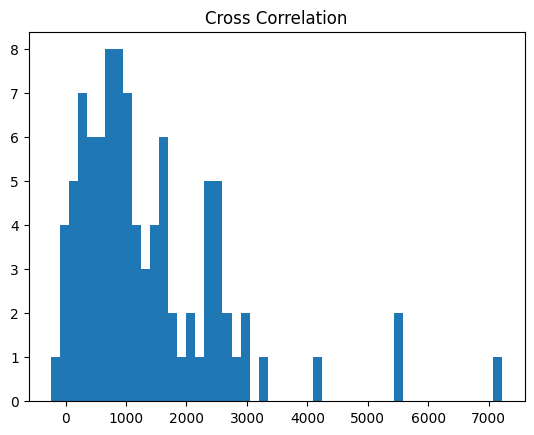

Mean: 1358.3861199447983
Median: 1035.025146484375
STD: 1240.7806542962849

Generalized Cross Correlation:


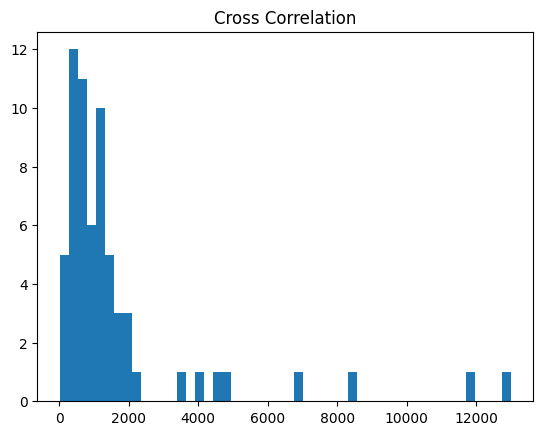

Mean: 1698.0453935861588
Median: 957.171142578125
STD: 2445.5555659315814

Lateralized Coherence:


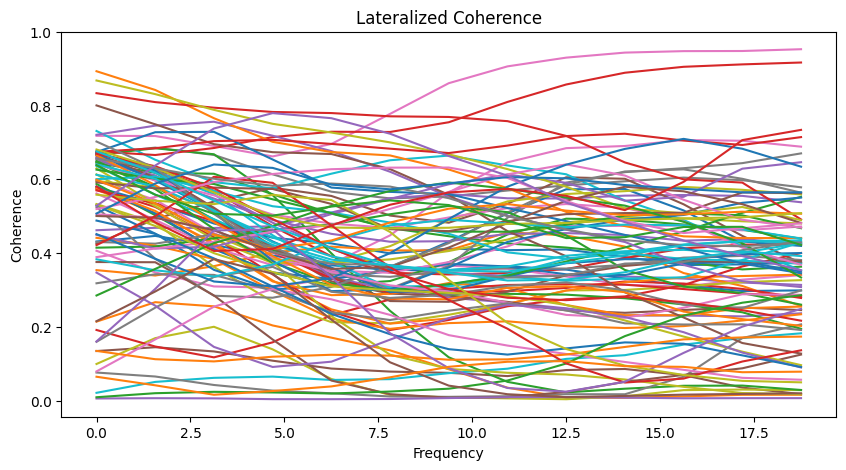


Generalized Coherence


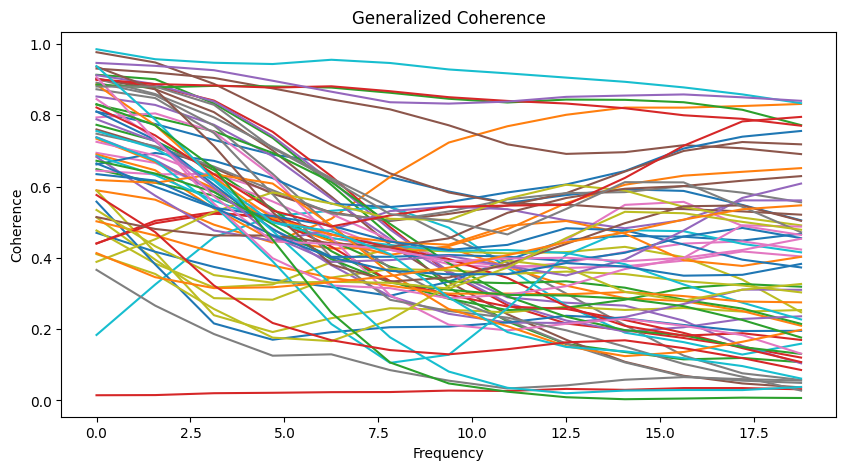


Lateralized Coherence Differences:


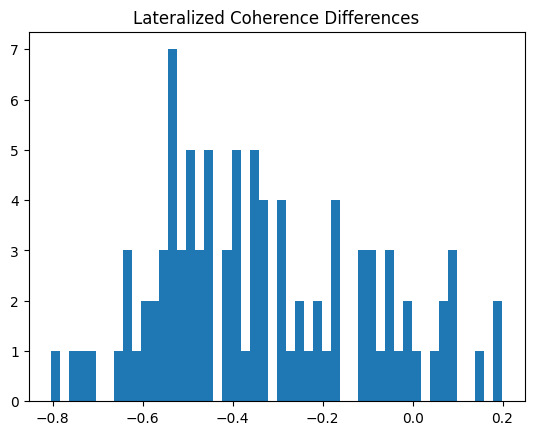

Mean: -0.33330536067093675
Median: -0.38202720880508423
STD: 0.23524931737518287

Generalized Coherence Differences:


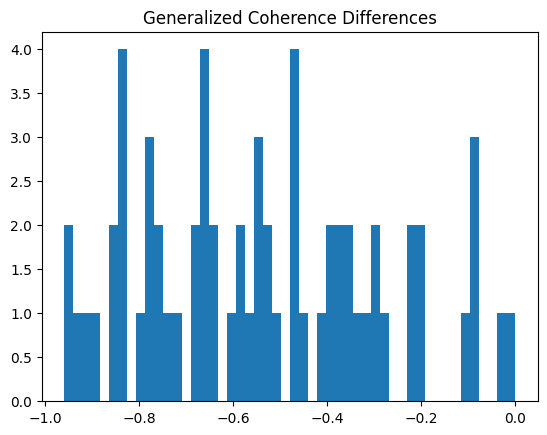

Mean: -0.5373311461207777
Median: -0.5500141382217407
STD: 0.25410600909171815

Lateralized Phase Lag Index:


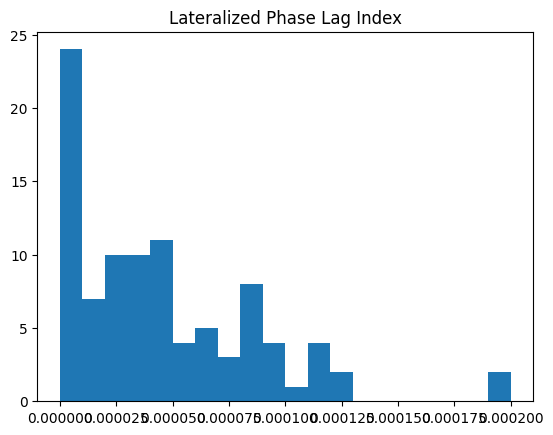

Mean: 4.445880602419376e-05
Median: 3.7313432835820896e-05
STD: 4.205402691727677e-05

Generalized Phase Lag Index:


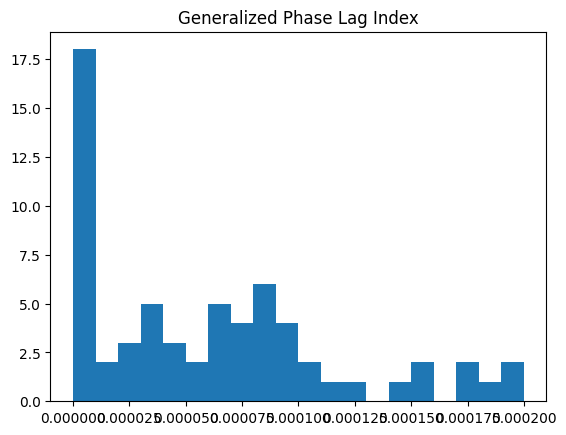

Mean: 6.081409906998788e-05
Median: 5.321557971014493e-05
STD: 5.609411842999674e-05


In [9]:
import sys
sys.path.insert(1, '../')
from src.utils.plot_eeg import plot_raw_eeg, to_bipolar, plot_bipolar_eeg

import torch
import numpy as np
from scipy.signal import coherence, welch
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_cross_correlation(signal1, signal2):
    # Ensure both signals are on CPU and convert to numpy for correlation computation
    correlation = np.correlate(signal1, signal2, mode='valid')
    result = torch.tensor(correlation)
    return torch.tensor(correlation)

def calculate_coherence(signal1, signal2, fs=200):
    # Convert signals to numpy and calculate coherence
    f, Cxy = coherence(signal1, signal2, fs=fs, window=hann(128), nperseg=128)

    # Apply smoothing to coherence values
    Cxy = np.convolve(Cxy, np.ones(3)/3, mode='valid')

    return torch.tensor(f), torch.tensor(Cxy)

def coherence_diff(signal1, signal2, fs=200):
    f, Cxy = coherence(signal1, signal2, fs=fs, window=hann(128), nperseg=128)
    return torch.tensor(Cxy[-1] - Cxy[0])


def calculate_phase_lag_index(signal1, signal2):
    # Convert signals to numpy for phase calculation
    signal1_np = signal1.cpu().numpy()
    signal2_np = signal2.cpu().numpy()
    
    # Compute the phase of the signals
    phase_signal1 = np.angle(np.fft.fft(signal1_np))
    phase_signal2 = np.angle(np.fft.fft(signal2_np))
    
    # Calculate the Phase Lag Index
    pli_matrix = np.sign(phase_signal1 - phase_signal2)
    pli = np.abs(np.sum(pli_matrix)) / len(signal1_np)
    return torch.tensor(pli)

def calculate_chain(eeg: pd.DataFrame, chain: str) -> torch.Tensor:
    CHAINS = {
        "LT": ("Fp1", "F7", "T3", "T5", "O1"),
        "RT": ("Fp2", "F8", "T4", "T6", "O2"),
        "LP": ("Fp1", "F3", "C3", "P3", "O1"),
        "RP": ("Fp2", "F4", "C4", "P4", "O2"),
        "C": ("Fz", "Cz", "Pz"),
    }
    bipolar = []
    for i in range(len(CHAINS[chain])-1):
        tmp = eeg[CHAINS[chain][i]] - eeg[CHAINS[chain][i+1]]
        bipolar.append(torch.Tensor(tmp.values))
    bipolar = torch.stack(bipolar)
    return bipolar.mean(dim=0)

def plot_coherence(coherence_values: dict[str, tuple[torch.tensor, torch.tensor]], max_freq: float, description="Coherence"):
    plt.figure(figsize=(10, 5))

    test = next(iter(coherence_values.values()))[0]
    mask = test > max_freq
    indices = mask.nonzero()
    max_freq_idx = indices[0] if len(indices) > 0 else None

    for id, coherence in coherence_values.items():
        plt.plot(coherence[0][:max_freq_idx], coherence[1][:max_freq_idx], label=id)
    plt.title(description)
    plt.xlabel('Frequency')
    plt.ylabel('Coherence')
    plt.show()

def cross_correlation_stats(cross_correlation_values: dict[str, float], metadata: pd.DataFrame):
    cross_correlation_values = {k: v for k, v in cross_correlation_values.items() if k in metadata['eeg_id'].values}
    plt.hist(list(cross_correlation_values.values()), bins=50)
    plt.title("Cross Correlation")
    plt.show()
    print("Mean:", np.mean(list(cross_correlation_values.values())))
    print("Median:", np.median(list(cross_correlation_values.values())))
    print("STD:", np.std(list(cross_correlation_values.values())))

# =============================================================================

fs = 200
cross_correlation_values = {}
cross_correlation_nans = []
coherence_values = {}
coherence_differences = {}
pli_values = {}

eeg_ids = list(metadata_lat['eeg_id'].values) + list(metadata_gen['eeg_id'].values)

for id in tqdm(eeg_ids):
    eeg = get_full_eeg_by_id_single_processed(id)

    # Calculate cross-correlation
    cc = calculate_cross_correlation(calculate_chain(eeg, "LT"), calculate_chain(eeg, "RT"))
    cross_correlation_values.update({id: cc[0].item()})
    
    # Calculate coherence
    f, Cxy = calculate_coherence(calculate_chain(eeg, "LT"), calculate_chain(eeg, "RT"), fs=fs)
    coherence_values.update({id: (f, Cxy)})

    # Coherece based feature
    difference = coherence_diff(calculate_chain(eeg, "LT"), calculate_chain(eeg, "RT"), fs=fs)
    coherence_differences.update({id: difference.item()})

    # Phase Lag Index
    pli = calculate_phase_lag_index(calculate_chain(eeg, "LT"), calculate_chain(eeg, "RT"))
    pli_values.update({id: pli.item()})


print("Found NaNs in cross-correlation values: ", len(cross_correlation_nans))

# Plot statistics and cross-correlation values
print("\n=====================================")
print("Lateralized Cross Correlation:")
cross_correlation_stats(cross_correlation_values, metadata_lat)

print("\n=====================================")
print("Generalized Cross Correlation:")
cross_correlation_stats(cross_correlation_values, metadata_gen)

# Plot all Coherence values
print("\n=====================================")
print("Lateralized Coherence:")
coherence_values_lat = {k: v for k, v in coherence_values.items() if k in metadata_lat['eeg_id'].values}
plot_coherence(coherence_values_lat, max_freq=20, description="Lateralized Coherence")

print("\n=====================================")
print("Generalized Coherence")
coherence_values_gen = {k: v for k, v in coherence_values.items() if k in metadata_gen['eeg_id'].values}
plot_coherence(coherence_values_gen, max_freq=20, description="Generalized Coherence")


# Display coherence differences
print("\n=====================================")
print("Lateralized Coherence Differences:")
coherence_differences_lat = {k: v for k, v in coherence_differences.items() if k in metadata_lat['eeg_id'].values}
plt.hist(list(coherence_differences_lat.values()), bins=50)
plt.title("Lateralized Coherence Differences")
plt.show()
print("Mean:", np.mean(list(coherence_differences_lat.values())))
print("Median:", np.median(list(coherence_differences_lat.values())))
print("STD:", np.std(list(coherence_differences_lat.values())))

print("\n=====================================")
print("Generalized Coherence Differences:")
coherence_differences_gen = {k: v for k, v in coherence_differences.items() if k in metadata_gen['eeg_id'].values}
plt.hist(list(coherence_differences_gen.values()), bins=50)
plt.title("Generalized Coherence Differences")
plt.show()
print("Mean:", np.mean(list(coherence_differences_gen.values())))
print("Median:", np.median(list(coherence_differences_gen.values())))
print("STD:", np.std(list(coherence_differences_gen.values())))

# Display PLI values
print("\n=====================================")
print("Lateralized Phase Lag Index:")
pli_values_lat = {k: v for k, v in pli_values.items() if k in metadata_lat['eeg_id'].values}
plt.hist(list(pli_values_lat.values()), bins=20)
plt.title("Lateralized Phase Lag Index")
plt.show()
print("Mean:", np.mean(list(pli_values_lat.values())))
print("Median:", np.median(list(pli_values_lat.values())))
print("STD:", np.std(list(pli_values_lat.values())))

print("\n=====================================")
print("Generalized Phase Lag Index:")
pli_values_gen = {k: v for k, v in pli_values.items() if k in metadata_gen['eeg_id'].values}
plt.hist(list(pli_values_gen.values()), bins=20)
plt.title("Generalized Phase Lag Index")
plt.show()
print("Mean:", np.mean(list(pli_values_gen.values())))
print("Median:", np.median(list(pli_values_gen.values())))
print("STD:", np.std(list(pli_values_gen.values())))
